In [2]:
import pandas as pd
import numpy as np
#import umap
from scipy.stats import sem
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from skbio.diversity.alpha import faith_pd
from skbio.diversity.alpha import shannon
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr, spearmanr
from scipy.stats import linregress
from sklearn.metrics import r2_score
from skbio import TreeNode
from scipy.integrate import simpson

# Phylum level difference

In [69]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_meta = df_meta[df_meta.Day==0]
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0)
df_tax = pd.read_csv('../../our_data/taxonomy.csv')
df_bac = pd.merge(df_bac, df_tax[['ASV','Phylum']].set_index('ASV'), left_index=True, right_index=True, how='left').fillna('<not present>')
df_bac = df_bac.groupby('Phylum').agg(np.sum).T
df_bac = df_bac[['Bacteroidota','Firmicutes']]
df_bac['BFR'] = df_bac.Bacteroidota/df_bac.Firmicutes
df_bac = pd.merge(df_bac, df_meta[['Vendor']], left_index=True, right_index=True, how='inner')
df_bac.index.name='SampleID'
df_bac['Feature'] = 'Feature'
df_bac['BFS'] = df_bac.Bacteroidota+df_bac.Firmicutes

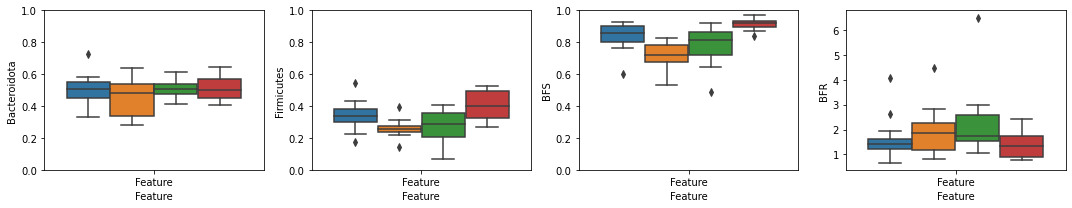

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,3), sharex=True)

for k,f in enumerate(['Bacteroidota','Firmicutes','BFS','BFR']):
    _ = sns.boxplot(x='Feature', y=f, hue='Vendor', data=df_bac, ax=ax[k])
    
    # get statistical test P value
    
    
    if k!=3:
        _ = ax[k].set_ylim([0,1])
    _  =ax[k].legend().remove()
        
plt.tight_layout()

# Plot UMAP (separate vendors)

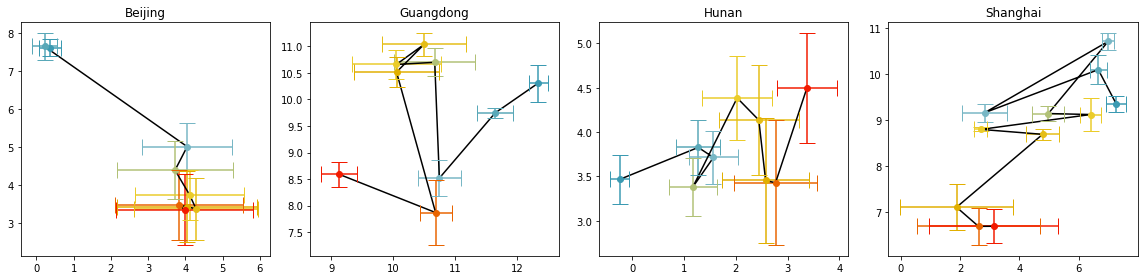

In [80]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0).T
asvs = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

colors = {0:'#3B9AB2',1:'#59A8B8',2:'#78B7C5',3:'#78B7C5',5:'#B1C177',8:'#EBCC2A',10:'#EBCC2A',13:'#E5BD15',19:'#E1AF00',25:'#E96400',31:'#F21A00'}
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df[df.Vendor==vendor]
    fit = umap.UMAP(random_state=0)
    u = fit.fit_transform(df_tmp[asvs].values)
    coef = pd.DataFrame(u, index=df_tmp.index, columns=['UMAP 1','UMAP 2'])
    df_coef = pd.merge(df_meta, coef, left_index=True, right_index=True, how='inner').sort_values(by='Day')
    umap_mean = df_coef.groupby(['Day']).agg(np.mean)
    umap_se = df_coef.groupby(['Day']).agg(sem)
    ax[k].plot(umap_mean['UMAP 1'], umap_mean['UMAP 2'], 'k-')  
    for day in [0,1,2,3,5,8,10,13,19,25,31]:
        if day in list(umap_mean.index):
            ax[k].plot(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 'o', color=colors[day], markerfacecolor=colors[day])
            ax[k].errorbar(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 
                           yerr=umap_se.loc[day,'UMAP 2'], xerr=umap_se.loc[day,'UMAP 1'],
                           fmt='', capsize=8, barsabove=False, capthick=None, ecolor=colors[day])
    ax[k].set_title(vendor)
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("microbiome_trajectory_umap_vendor_separate.svg", format="svg")

# Plot UMAP (combine all vendors)

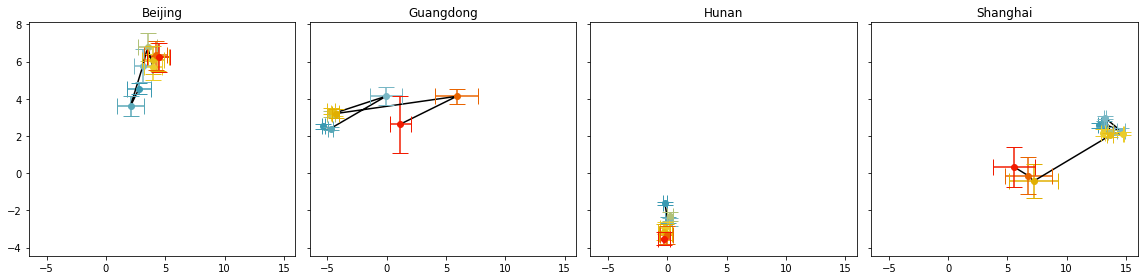

In [81]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0).T
asvs = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharex=True, sharey=True)

colors = {0:'#3B9AB2',1:'#59A8B8',2:'#78B7C5',3:'#78B7C5',5:'#B1C177',8:'#EBCC2A',10:'#EBCC2A',13:'#E5BD15',19:'#E1AF00',25:'#E96400',31:'#F21A00'}
fit = umap.UMAP(random_state=0)
u = fit.fit_transform(df[asvs].values)
coef = pd.DataFrame(u, index=df.index, columns=['UMAP 1','UMAP 2'])
df_coef = pd.merge(df_meta, coef, left_index=True, right_index=True, how='inner').sort_values(by='Day')
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_coef[df_coef.Vendor==vendor]
    umap_mean = df_tmp.groupby(['Day']).agg(np.mean)
    umap_se = df_tmp.groupby(['Day']).agg(sem)
    ax[k].plot(umap_mean['UMAP 1'], umap_mean['UMAP 2'], 'k-')  
    for day in [0,1,2,3,5,8,10,13,19,25,31]:
        if day in list(umap_mean.index):
            ax[k].plot(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 'o', color=colors[day], markerfacecolor=colors[day])
            ax[k].errorbar(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 
                           yerr=umap_se.loc[day,'UMAP 2'], xerr=umap_se.loc[day,'UMAP 1'],
                           fmt='', capsize=8, barsabove=False, capthick=None, ecolor=colors[day])
    ax[k].set_title(vendor)
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("microbiome_trajectory_umap_vendor_combined.svg", format="svg")

# Plot correlation between alpha diversity and SCFA

<ipython-input-15-51cb07dd37e1>:3: RuntimeWarning: divide by zero encountered in log2
  df_alpha_diversity = -np.sum(df_bac*np.log2(df_bac)).to_frame()


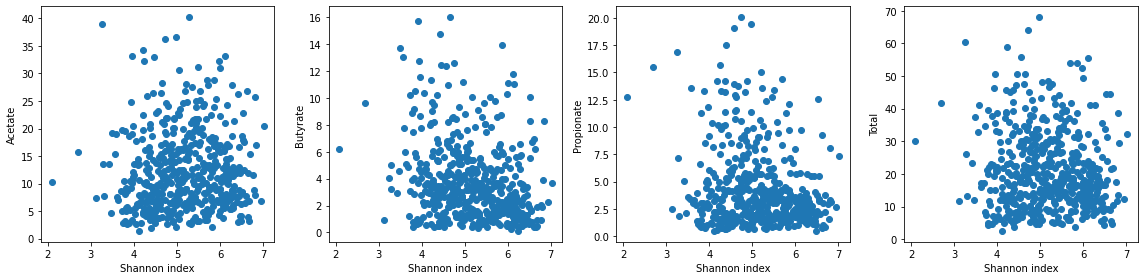

In [15]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0)
df_alpha_diversity = -np.sum(df_bac*np.log2(df_bac)).to_frame()
df_alpha_diversity.columns = ['AlphaDiversity']
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df = pd.merge(df_scfa, df_alpha_diversity, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharex=True)

for k,scfa in enumerate(['Acetate','Butyrate','Propionate','Total']):
    _ = ax[k].scatter(df['AlphaDiversity'], df[scfa], marker='o')
    _ = ax[k].set_xlabel('Shannon index')
    _ = ax[k].set_ylabel(scfa)
    
plt.tight_layout()

# Plot dynamics of iso-butyrate, iso-valerate, and valerate

In [ ]:
#df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
#df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
#df_scfa = df_scfa[['Iso-butyrate','Iso-valerate','Valerate']]
# df_scfa = df_scfa.clip(lower=0)
# df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(8,8), sharex=True, sharey=True)

# for k1,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
#     df_tmp = df[(df.Vendor==vendor)]
#     for k2,scfa in enumerate(['Iso-butyrate','Iso-valerate','Valerate']):
#         _ = sns.lineplot(x='Day', y=scfa, hue='Diet', data=df_tmp, ci=68, marker='o', ax=ax[k1,k2])
#         ax[k1,k2].legend().remove()
#         ax[k1,k2].set_ylabel(vendor)
#         if k1 ==0:
#             ax[k1,k2].set_title(scfa)
#         ax[k1,k2].set_yticks([0,0.4,0.8])
#         ax[k1,k2].set_xticks([0,5,10,15,20,25,30])
# plt.tight_layout()

# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("dynamics_of_other_scfa.svg", format="svg")

# Compare inulin and resistant starch stimulation

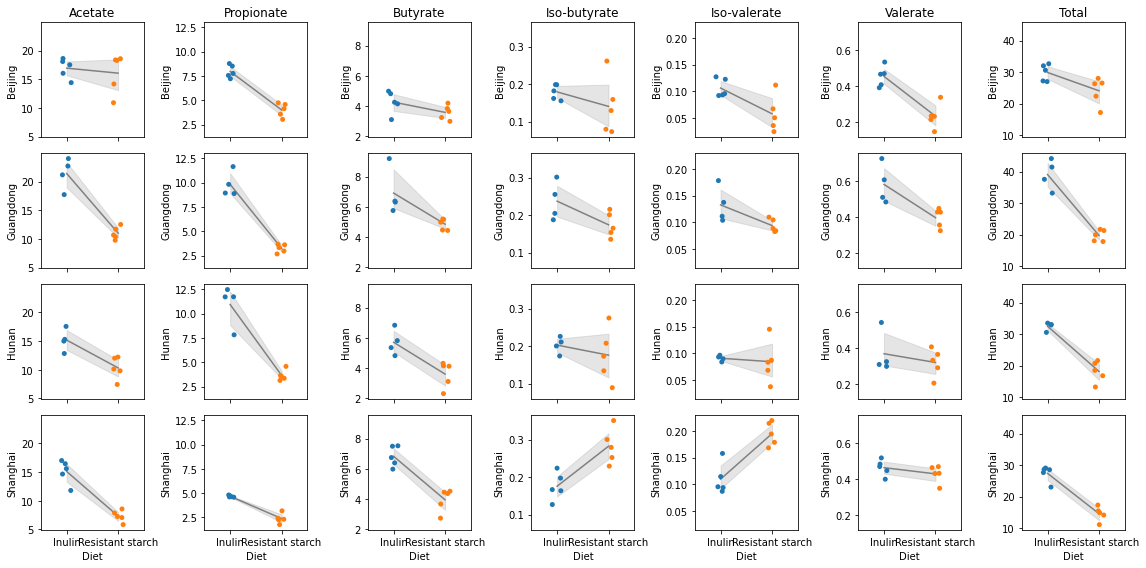

In [41]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df_scfa = df_scfa.clip(lower=0)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

# calculate area under the curve
lines = []
for miceid in set(df.MiceID):
    vendor = list(set(df.loc[df.MiceID==miceid,'Vendor']))
    assert len(vendor)==1
    vendor = vendor[0]
    for diet in ['Inulin','Resistant starch']:
        df_tmp = df[(df.MiceID==miceid)&(df.Diet==diet)].sort_values(by='Day')
        if len(df_tmp) != 0:
            for scfa in df_scfa.columns:
                x = df_tmp.Day
                y = df_tmp[scfa]
                area = simpson(y,x)/np.max(x)
                lines.append([miceid,vendor,diet,scfa,area])
df_area = pd.DataFrame(lines, columns=['MiceID','Vendor','Diet','SCFA','Mean'])

fig, ax = plt.subplots(nrows=4, ncols=len(df_scfa.columns), figsize=(16,8), sharex=True, sharey='col')

for k1,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    for k2,scfa in enumerate(df_scfa.columns):
        df_tmp = df_area[(df_area.Vendor==vendor)&(df_area.SCFA==scfa)].sort_values('Diet')
        _ = sns.lineplot(x='Diet',y='Mean',data=df_tmp, ax=ax[k1,k2], color='gray')
        _ = sns.stripplot(x='Diet', y='Mean', data=df_tmp, ax=ax[k1,k2])
        ax[k1,k2].set_ylabel(vendor)
        if k1==0:
            ax[k1,k2].set_title(scfa)
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("comparison_inulin_vs_rs.svg", format="svg")

# Compare SCFA level at initial, peak and final

In [50]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df_scfa = df_scfa.clip(lower=0)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

# calculate area under the curve
lines = []
for miceid in set(df.MiceID):
    vendor = list(set(df.loc[df.MiceID==miceid,'Vendor']))
    assert len(vendor)==1
    vendor = vendor[0]
    for diet in ['Inulin','Resistant starch']:
        df_tmp = df[(df.MiceID==miceid)&(df.Diet==diet)].sort_values(by='Day')
        if len(df_tmp) != 0:
            for scfa in df_scfa.columns:
                y = list(df_tmp[scfa])
                inity = y[0]
                peaky = np.max(y)
                finaly = y[-1]
                lines.append([miceid,vendor,diet,scfa,inity, peaky, finaly])
df = pd.DataFrame(lines, columns=['MiceID','Vendor','Diet','SCFA','InitConc','PeakConc','FinalConc'])

for diet in ['Inulin','Resistant starch']:
    for vendor in ['Beijing','Guangdong','Hunan','Shanghai']:
        df_tmp = df[(df.Vendor==vendor) & (df.Diet==diet) & (df.SCFA=='Total')]
        fracOfPeak = np.mean(df_tmp.FinalConc/df_tmp.PeakConc)
        fracOfInit = np.mean(df_tmp.FinalConc/df_tmp.InitConc)
        print(diet, vendor, fracOfPeak, fracOfInit)

Inulin Beijing 0.6431989359696245 2.042520652918752
Inulin Guangdong 0.6296615948189853 2.2748909846509906
Inulin Hunan 0.6066312162800261 3.277233585302793
Inulin Shanghai 0.6486224200430802 2.3329380961194315
Resistant starch Beijing 0.9587670355971689 1.9834639965906913
Resistant starch Guangdong 0.4090342994083388 1.07645940056657
Resistant starch Hunan 0.780575308155798 1.5102306165713206
Resistant starch Shanghai 0.6615588340181142 1.4882694809277324


# Plot dyanmics of Parabacteroides distasonis and Bacteroides uniformis

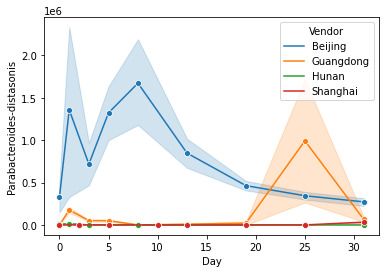

In [13]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
df_bac = df_bac[['Parabacteroides-distasonis']]
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df = df[df.Diet=='Inulin']
ax = sns.lineplot(x='Day', y='Parabacteroides-distasonis', hue='Vendor', data=df, ci=68, marker='o')
# ax.set_yscale('log')
# ax.set_ylim([1,1e7])

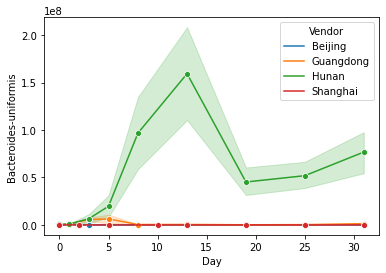

In [16]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
df_bac = df_bac[['Bacteroides-uniformis']]
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df = df[df.Diet=='Inulin']
ax = sns.lineplot(x='Day', y='Bacteroides-uniformis', hue='Vendor', data=df, ci=68, marker='o')
#ax.set_yscale('log')
# ax.set_ylim([1,1e7])

# Scatterplot of unclassified Parabacteroides and propionate production rate

In [4]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
species = list(df_bac.columns)
df_scfa = pd.read_csv('../../our_data/SCFA.csv', index_col=0)
df_scfa = df_scfa[['Propionate']]

# calculate SCFA derivatives
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv_meta = deepcopy(df_scfa_meta)
df_scfa_deriv_meta = df_scfa_deriv_meta.rename({'Propionate':'Propionate_deriv'}, axis=1)
for mouse in set(df_scfa_deriv_meta.MiceID):
    curr_df = df_scfa_meta[df_scfa_meta.MiceID==mouse].sort_values(by='Day')
    xdata = np.array(curr_df['Day'])
    ydata = np.array(curr_df['Propionate'])
    cs = CubicSpline(xdata, ydata)
    csd1 = cs.derivative(nu=1)
    ydata_d1 = csd1(xdata)
    df_scfa_deriv_meta.loc[df_scfa_deriv_meta.MiceID==mouse, 'Propionate_deriv'] = ydata_d1
df = pd.merge(df_scfa_deriv_meta, df_scfa, left_index=True, right_index=True, how='inner')
df = pd.merge(df, df_bac, left_index=True, right_index=True, how='inner')

## inulin

In [5]:
df_inulin = df[df.Diet=='Inulin']
df_0 = df_inulin[df_inulin.Day==0]
df_0 = df_0.loc[:, (df_0 != df_0.iloc[0]).any()] 
df_1 = df_inulin[df_inulin.Day>0]
df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()]

# correlate baseline microbiota with derivative
corr_baseline_ppa_deriv = []
for s in species:
    if s in list(df_0.columns):
        xdata = np.asarray(df_0[s])
        ydata = np.asarray(df_0['Propionate_deriv'])
        slope, intercept, r_value, p_value, std_err = linregress(x=xdata, y=ydata)
        ydata_prediction = intercept+ slope*xdata
        pcorr = pearsonr(xdata, ydata)[0]
        scorr = spearmanr(xdata, ydata)[0]
        r2 = r2_score(ydata, ydata_prediction)
        corr_baseline_ppa_deriv.append([s, pcorr, scorr, r2])
df_corr_baseline_ppa_deriv = pd.DataFrame(corr_baseline_ppa_deriv, columns=['Species','Pearson','Spearman','R2'])
df_corr_baseline_ppa_deriv.sort_values(by='R2', ascending=False).head()

,Species,Pearson,Spearman,R2
145,Parabacteroides,0.710463,0.455108,0.504758
202,mouse-gut-metagenome,0.671433,0.608616,0.450822
148,Parabacteroides-merdae,0.631874,0.066597,0.399264
80,Enterobacteriaceae,0.584308,0.352347,0.341416
84,Erysipelatoclostridium-ramosum,0.577562,0.397360,0.333578


0.7104632159237145 0.000952322940705558
0.7104632159237145 0.45510835913312697 0.5047579811806664
0.21016763727665655 0.014794910535951777
0.21016763727665655 0.04737712426199146 0.044170435758452364


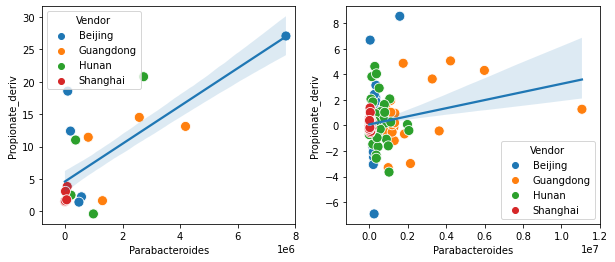

In [9]:
# scatterplot
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# day = 0
_ = sns.scatterplot(x='Parabacteroides', y='Propionate_deriv', hue='Vendor', data=df_0, ax=ax[0], s=100)
p = sns.regplot(x='Parabacteroides', y='Propionate_deriv', data=df_0, ax=ax[0], scatter=False, ci=68)
xdata = np.asarray(df_0.Parabacteroides)
ydata = np.asarray(df_0.Propionate_deriv)
slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
print(r_value, p_value)
ydata_prediction = intercept+ slope*xdata
pcorr = pearsonr(xdata, ydata)[0]
scorr = spearmanr(xdata, ydata)[0]
r2 = r2_score(ydata, ydata_prediction)
print(pcorr, scorr, r2)
_ = ax[0].set_xlim([-8e5, 8e6])

# day > 0
_ = sns.scatterplot(x='Parabacteroides', y='Propionate_deriv', hue='Vendor', data=df_1, ax=ax[1], s=100)
p = sns.regplot(x='Parabacteroides', y='Propionate_deriv', data=df_1, ax=ax[1], scatter=False, ci=68)
xdata = np.asarray(df_1.Parabacteroides)
ydata = np.asarray(df_1.Propionate_deriv)
slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
print(r_value, p_value)
ydata_prediction = intercept+ slope*xdata
pcorr = pearsonr(xdata, ydata)[0]
scorr = spearmanr(xdata, ydata)[0]
r2 = r2_score(ydata, ydata_prediction)
print(pcorr, scorr, r2)
_ = ax[1].set_xlim([-1.2e6, 1.2e7])

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_baseline_Parabacteroides_propionate_production_rate.svg", format="svg")

## Resistant starch

In [15]:
df_rs = df[df.Diet=='Resistant starch']
df_0 = df_rs[df_rs.Day==0]
df_0 = df_0.loc[:, (df_0 != df_0.iloc[0]).any()] 
df_1 = df_rs[df_rs.Day>0]
df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()]

# correlate baseline microbiota with derivative
corr_baseline_ppa_deriv = []
for s in species:
    if s in list(df_0.columns):
        xdata = np.asarray(df_0[s])
        ydata = np.asarray(df_0['Propionate_deriv'])
        slope, intercept, r_value, p_value, std_err = linregress(x=xdata, y=ydata)
        ydata_prediction = intercept+ slope*xdata
        pcorr = pearsonr(xdata, ydata)[0]
        scorr = spearmanr(xdata, ydata)[0]
        r2 = r2_score(ydata, ydata_prediction)
        corr_baseline_ppa_deriv.append([s, pcorr, scorr, r2])
df_corr_baseline_ppa_deriv = pd.DataFrame(corr_baseline_ppa_deriv, columns=['Species','Pearson','Spearman','R2'])
df_corr_baseline_ppa_deriv.sort_values(by='R2', ascending=False).head()

,Species,Pearson,Spearman,R2
39,Burkholderiales,0.533490,0.377964,0.284612
22,Bacillus,0.533490,0.377964,0.284612
57,Clostridiales-bacterium-CIEAF-020,0.530024,0.166296,0.280926
162,Ruminiclostridium,-0.521973,-0.377964,0.272456
176,Vagococcus,-0.521973,-0.377964,0.272456
